In [1]:
import anndata
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
import seaborn as sns

from dredFISH.Utils import basicu

In [2]:
f = '../data_dump/counts/P28_nr_allcells_Oct24.h5ad'
adata_nr = anndata.read(f)
adata_nr

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 23930 × 53547
    obs: 'cov', 'covfactor', 'batch', 'n_genes', 'percent_mito', 'n_counts', 'leiden', 'Doublet', 'Doublet Score', 'Class_broad', 'sample', 'Type', 'Subclass'
    var: 'id'

In [3]:
f = '../data_dump/counts/P28_dr_allcells_Oct25.h5ad'
adata_dr = anndata.read(f)
adata_dr

/home/fangming/anaconda3/envs/routine/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 24816 × 53547
    obs: 'cov', 'covfactor', 'n_genes', 'percent_mito', 'n_counts', 'Doublet', 'Doublet Score', 'batch', 'leiden', 'sample', 'Type', 'Subclass'
    var: 'id'

In [4]:
def get_normed_bulks(mat, genes, types):
    """
    - select expressed genes
    - sparse to dense
    - merge cells to clusters
    - log10(CPM+1) norm bulk samples
    """
    ncell, ngene = mat.shape
    cellcov = np.asarray(mat.sum(axis=1)).reshape(-1,)
    genecov = np.asarray(mat.sum(axis=0)).reshape(-1,)
    cond = genecov>ncell*0.01 # expressed in at least 1% of cells
    matsub = np.asarray(mat[:,cond].todense())
    
    # pseudo-bulk samples -- pull counts from cells
    Xk, xclsts = basicu.group_sum(matsub, types)
    ck, xclsts = basicu.group_sum(cellcov.reshape(-1,1), types)
    Xk = np.log10(1+(np.array(Xk)/np.array(ck))*1e6) # log10(1+CPM)
    df = pd.DataFrame(Xk, index=xclsts, columns=genes[cond])
    return df.T # gene by types 

def get_normed_bulks_for_adata_by_types(adata):
    """
    """
    return get_normed_bulks(adata.X.copy(), adata.var.index.values, adata.obs['Type'])

In [5]:
samples_nr = np.unique(adata_nr.obs['sample'])
samples_dr = np.unique(adata_dr.obs['sample'])
samples_nr, samples_dr

(array(['P28_1a', 'P28_1b', 'P28_2a', 'P28_2b'], dtype=object),
 array(['P28_dr_1a', 'P28_dr_1b', 'P28_dr_3a', 'P28_dr_3b'], dtype=object))

In [6]:
%%time
dfs_nr = []
for samp in samples_nr:
    adatasub = adata_nr[adata_nr.obs['sample']==samp]
    df = get_normed_bulks_for_adata_by_types(adatasub)
    print(df.shape)
    dfs_nr.append(df)

dfs_dr = []
for samp in samples_dr:
    adatasub = adata_dr[adata_dr.obs['sample']==samp]
    df = get_normed_bulks_for_adata_by_types(adatasub)
    print(df.shape)
    dfs_dr.append(df)
    

(15758, 42)
(15689, 42)
(15412, 42)
(15175, 42)
(15642, 42)
(15676, 42)
(14851, 42)
(14787, 42)
CPU times: user 5.29 s, sys: 36.2 s, total: 41.4 s
Wall time: 41.8 s


In [7]:
genes_comm = adata_nr.var.index.values
for df in dfs_nr:
    genes_comm = np.intersect1d(genes_comm, df.index.values)
    print(genes_comm.shape)
for df in dfs_dr:
    genes_comm = np.intersect1d(genes_comm, df.index.values)
    print(genes_comm.shape)
    
for i in range(4):
    dfs_nr[i] = dfs_nr[i].loc[genes_comm]
    dfs_dr[i] = dfs_dr[i].loc[genes_comm]

(15758,)
(15505,)
(14961,)
(14715,)
(14498,)
(14451,)
(14242,)
(14165,)


In [8]:
# # check
# for df in dfs_nr:
#     print(df.shape, df.columns.values)
# for df in dfs_dr:
#     print(df.shape, df.columns.values)

In [9]:
tensor_nr = np.stack(dfs_nr, axis=2)
tensor_dr = np.stack(dfs_dr, axis=2)
tensor_nr.shape, tensor_dr.shape

((14165, 42, 4), (14165, 42, 4))

In [10]:
# for each gene and cell type; 4 rep vs 4 rep - t-test and p-val correction 
lfc = np.mean(tensor_dr, axis=2) - np.mean(tensor_nr, axis=2) # log10FC (log10CPM as raw counts)
minexp = np.minimum(np.mean(tensor_dr, axis=2), np.mean(tensor_nr, axis=2)) # min log10CPM 
ts, ps = ttest_ind(tensor_nr, tensor_dr, axis=2)
rejs, qs, _, _ = multipletests(np.nan_to_num(ps, 1).reshape(-1,), method='fdr_bh')
rejs = rejs.reshape(ps.shape)
qs = qs.reshape(ps.shape)

In [11]:
lfc.shape, rejs.shape, qs.shape, np.sum(np.sum(rejs, axis=1) > 0), np.sum(rejs, axis=0) 

((14165, 42),
 (14165, 42),
 (14165, 42),
 7953,
 array([ 650,  337,  230,  330,  421, 1329, 2972,  941,  457,  520,  518,
         131,  433,  268,  263,  941,  416,  776,  132,  245,  195,  136,
         343,  192,  561,   85, 1368,  220,  283,  404,  271,  511,  436,
         262,  411,  535, 1251,  784,  444,  410,  496,  739]))

In [12]:
sigsigs = np.logical_and(np.logical_and(rejs, (np.abs(lfc) > np.log10(2))), minexp > np.log10(1+1)) # FDR < 0.05; FC > 2; min mean CPM > 1
sigsigs.shape, np.sum(np.sum(sigsigs, axis=1) > 0), np.sum(sigsigs, axis=0)

((14165, 42),
 2319,
 array([ 211,   27,   44,   40,   81,  421, 1345,  138,   93,   86,   88,
          11,   67,    6,   10,  198,   49,  150,    9,   45,   34,   27,
          56,   28,   45,    7,    3,    7,   17,   19,    9,  122,   13,
          13,    6,   37,    5,    5,    8,   31,   26,   28]))

In [13]:
sigsigs_up = np.logical_and(np.logical_and(rejs, (lfc > np.log10(2))), minexp > np.log10(1+1)) # FDR < 0.05; FC > 2; min mean CPM > 1
sigsigs_up.shape, np.sum(np.sum(sigsigs_up, axis=1) > 0), np.sum(sigsigs_up, axis=0)

((14165, 42),
 967,
 array([140,  11,  30,   9,  57, 259, 468,  89,  48,  54,  52,   7,  47,
          2,   8, 147,  33, 116,   5,  34,  23,  22,   8,   9,  13,   4,
          2,   3,   9,   5,   2,  79,   6,   2,   2,  26,   2,   3,   4,
         20,  11,  17]))

In [14]:
sigsigs_dn = np.logical_and(np.logical_and(rejs, (lfc < -np.log10(2))), minexp > np.log10(1+1)) # FDR < 0.05; FC > 2; min mean CPM > 1
sigsigs_dn.shape, np.sum(np.sum(sigsigs_dn, axis=1) > 0), np.sum(sigsigs_dn, axis=0)

((14165, 42),
 1453,
 array([ 71,  16,  14,  31,  24, 162, 877,  49,  45,  32,  36,   4,  20,
          4,   2,  51,  16,  34,   4,  11,  11,   5,  48,  19,  32,   3,
          1,   4,   8,  14,   7,  43,   7,  11,   4,  11,   3,   2,   4,
         11,  15,  11]))

In [15]:
# show results
unq_types = dfs_nr[0].columns.values
unq_types

array(['Astro_A', 'Astro_B', 'Endo', 'Frem1', 'L2/3_A', 'L2/3_B',
       'L2/3_C', 'L4_A', 'L4_B', 'L4_C', 'L5IT', 'L5NP', 'L5PT_A',
       'L5PT_B', 'L6CT_A', 'L6CT_B', 'L6CT_C', 'L6IT_A', 'L6IT_B', 'L6b',
       'Lamp5', 'Micro', 'OD_A', 'OD_B', 'OD_C', 'OPC_A', 'OPC_B',
       'Pvalb_A', 'Pvalb_B', 'Pvalb_C', 'Pvalb_D', 'Sst_A', 'Sst_B',
       'Sst_C', 'Sst_D', 'Sst_E', 'Stac', 'VLMC_A', 'VLMC_B', 'Vip_A',
       'Vip_B', 'Vip_C'], dtype=object)

In [16]:
for a, b, c in zip(
    unq_types,
    np.sum(sigsigs_up, axis=0),
    np.sum(sigsigs_dn, axis=0),
    ):
    print(a,b,c)
    

Astro_A 140 71
Astro_B 11 16
Endo 30 14
Frem1 9 31
L2/3_A 57 24
L2/3_B 259 162
L2/3_C 468 877
L4_A 89 49
L4_B 48 45
L4_C 54 32
L5IT 52 36
L5NP 7 4
L5PT_A 47 20
L5PT_B 2 4
L6CT_A 8 2
L6CT_B 147 51
L6CT_C 33 16
L6IT_A 116 34
L6IT_B 5 4
L6b 34 11
Lamp5 23 11
Micro 22 5
OD_A 8 48
OD_B 9 19
OD_C 13 32
OPC_A 4 3
OPC_B 2 1
Pvalb_A 3 4
Pvalb_B 9 8
Pvalb_C 5 14
Pvalb_D 2 7
Sst_A 79 43
Sst_B 6 7
Sst_C 2 11
Sst_D 2 4
Sst_E 26 11
Stac 2 3
VLMC_A 3 2
VLMC_B 4 4
Vip_A 20 11
Vip_B 11 15
Vip_C 17 11


In [17]:
a = tensor_nr[sigsigs_up[:,0],0,:] 
b = tensor_dr[sigsigs_up[:,0],0,:] 
ab = np.hstack([a,b])

a = tensor_nr[sigsigs_dn[:,0],0,:] 
b = tensor_dr[sigsigs_dn[:,0],0,:] 
ab2 = np.hstack([a,b])
ab = np.vstack([ab,ab2])

ab = (ab - np.mean(ab, axis=1).reshape(-1,1)) #/np.std(ab, axis=1).reshape(-1,1)

<AxesSubplot:>

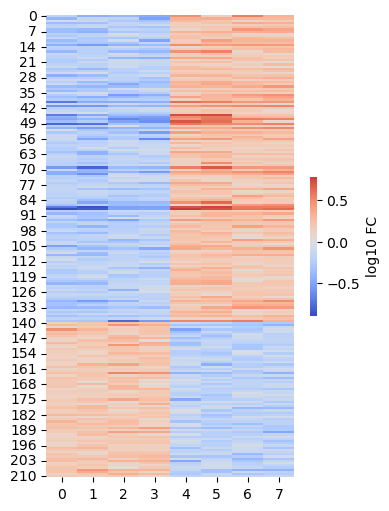

In [18]:
fig, ax = plt.subplots(figsize=(4,6))
sns.heatmap(ab, center=0, cmap='coolwarm', cbar_kws=dict(shrink=0.3, label='log10 FC'))

In [19]:
# focus on non cells
# read the cell paper Methods?